# Lensing Tutorial Part 1

### Modified from the SPTpol lensing tutorial at /scratch/wlwu/lensing_tutorial/Lensing_tutorial_3G.ipynb.

This is based on the parameter file `/home/panz/code/spt3g_software/lensing/specific_analyses/lens3g/params/par_run_150ghz_12.py`. Also see `/home/panz/code/spt3g_software/lensing/specific_analyses/lens3g/params/par_run_150ghz_06.py`.

In this first tutorial, we will take simple sims and define all the classes and parameters that we need to get the quadratic estimator. We do many sanity checks along the way to make sure everything is right.

SPT3G uses 4 major classes in the lensing pipeline: `obs`, `cinv`, `qest`, and `qecl`. Roughly, the `obs` class handles the mock observed signal and noise simulations; the `cinv` class then contains the inverse variance filtered sims; `qest` then takes 2 CMB input maps and computes the quadratic estimator $\phi$; and finally, `qecl` has the $C_\ell$ spectra of the $\phi$s.

### Import packages

In [22]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import sys
import os
sys.path.append("/home/yukanakato/spt3g_software/build/")
sys.path.append("/home/yukanakato/spt3g_software/mapspectra/python")
import os, scipy, hashlib, glob, subprocess, imp, pdb, copy
from builtins import zip
import pickle as pk
import healpy as hp
import numpy  as np
import pylab  as pl
import datetime
import glob
from spt3g import lensing as sl
from spt3g import core, maps
from spt3g.maps import FlatSkyMap
from spt3g.mapspectra import MapSpectrum1D, MapSpectrum2D, basicmaputils
from spt3g.lensing.map_spec_utils import MapSpectraTEB
from spt3g.lensing import map_spec_utils, utils
from spt3g.mapspectra import map_analysis
from pixel_window import pixwin_flatsky
from spt3g.simulations.instrument import get_beams
from platform import python_version

uK = core.G3Units.uK
arcmin = core.G3Units.arcmin
print(np.__version__) # Should have at least 1.15.0

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


1.15.0


### Define related parameters

In [23]:
# Ell space cuts
lmax_sinv = 5400 # Cut off the filtered signal at this value
lmax_cinv = 5400 # Cut off the cinv filtered fields at this value

# For data analysis we would want min lx
lmin_cinv = 1
lxmin_cinv = 1

# T to P leakage and polarization calibration coefficients
tq_leak = 0.00463
tu_leak = 0.01278

# Polarization calibration factor
# Note that polcal is already corrected for the data or sims
pcal = 1.05

# Name prefixes, used to name the data folders
ivfs_prefix = "run_01"
qest_prefix = "run_01"

# Specify which sims are used for which quadratic cl estimator (qecl)
nsim = 500
mc_sims = np.arange(0,nsim) # Indices for all sims
mc_sims_mf = mc_sims[0:160] # These are the sims used for mean field estimation
mc_sims_var = mc_sims[160:500] # Variance
mc_sims_unl = mc_sims_var # Unlensed sims
mc_sims_qcr_mc = mc_sims_var # The qcr, normalization calculation
mc_sims_n0 = mc_sims # N0 bias
mc_sims_n1 = mc_sims[4:164] # N1 bias

### Load simulations from the obs class

We use simulations to estimate the variance, noise biases, and the normalization of the lensing power spectrum. The simulations are treated similarly to the data and have the same transfer function as the data. This requires using mock-observed simulations. 

The mock-observed SPT simulations used for this analysis were saved in numpy data arrays.

In [24]:
lib_dir = '/home/yukanakato/spt3g_software_tutorial/qest/run_01/'

res = 2*arcmin
ny = 390
nx = 390
# 3G full survey projected depth at 150 GHz has the below noise levels
nlev_t = 2.2*uK*arcmin # In G3 units
nlev_p = np.sqrt(2) * nlev_t

parent = FlatSkyMap(nx, ny, res,
                    alpha_center=0.0*core.G3Units.deg,
                    delta_center=-57.5*core.G3Units.deg,
                    proj=maps.MapProjection.ProjZEA,
                    coord_ref=maps.MapCoordReference.Equatorial,
                    pol_conv=maps.MapPolConv.IAU,)

# CMB only (no foregrounds), no filtering simulation maps (these projected maps are not beamed, i.e. bl is np.ones(lmax))
cmblib_len_t1p1 = sl.obs.SimLib(lib_dir=lib_dir+'sims_t1p1/', name_fmt='sim_{:n}.g3', parent=parent)
cmblib_len_t2p1_nofg = sl.obs.SimLib(lib_dir=lib_dir+'sims_t2p1/', name_fmt='sim_{:n}.g3', parent=parent)
cmblib_unl_t1p1 = sl.obs.SimLib(lib_dir=lib_dir+'sims_unl/', name_fmt='sim_{:n}.g3', parent=parent)
cmblib_kap = sl.obs.SimLib(lib_dir=lib_dir+'sims_kap/', parent=parent, name_fmt='sim_{:n}.g3')

# Theory spectra
lmax_theoryspec = 5400 # Cut off the theory spectrum at this value  
cl_unl = sl.map_spec_utils.get_camb_scalcl(prefix="planck18_TTEEEE_lowl_lowE_lensing_highacc", lmax=lmax_theoryspec)
cl_unl["BB"] = np.zeros(lmax_theoryspec+1)
cl_len = sl.map_spec_utils.get_camb_lensedcl(prefix="planck18_TTEEEE_lowl_lowE_lensing_highacc", lmax=lmax_theoryspec)
cltt = cl_len["TT"]
clee = cl_len["EE"]
clbb = cl_len["BB"]
# To go from noise levels in uK-arcmin to its power spectrum, calculate the variance of the noise fluctuations
nltt = (nlev_t/uK/arcmin)**2 * (np.pi/180/60)**2 # np.pi/180 converts degrees to radians, 1/60 converts arcmin to degrees
nlee = (nlev_p/uK/arcmin)**2 * (np.pi/180/60)**2
nlbb = (nlev_p/uK/arcmin)**2 * (np.pi/180/60)**2
# Convert back to G3 units to avoid confusion
nltt = nltt * uK**2
nlee = nlee * uK**2
nlbb = nlbb * uK**2

### Plot the T map from one sim

In [25]:
# First check frame
frames = list(core.G3File(lib_dir+'sims_t1p1/sim_0.g3'))
for f in frames:
    print(f)

Frame (Map) [
"Id" (spt3g.core.G3String) => "SPT3G_sim"
"Q" (spt3g.maps.FlatSkyMap) => 390 x 390 (13 x 13 deg) ZEA centered at (194.5, 194.5) = (0, -57.5 deg) in equatorial coordinates  (Tcmb)
"T" (spt3g.maps.FlatSkyMap) => 390 x 390 (13 x 13 deg) ZEA centered at (194.5, 194.5) = (0, -57.5 deg) in equatorial coordinates  (Tcmb)
"U" (spt3g.maps.FlatSkyMap) => 390 x 390 (13 x 13 deg) ZEA centered at (194.5, 194.5) = (0, -57.5 deg) in equatorial coordinates  (Tcmb)
]


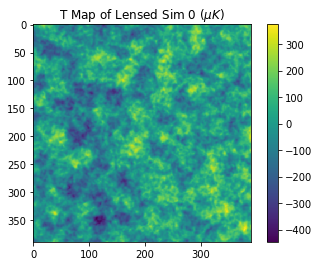

In [26]:
tqu_0 = cmblib_len_t1p1.get_sim(0) # Extract simulation indexed 0
pl.imshow(tqu_0['T']/uK) # Plot in IAU convention
pl.title('T Map of Lensed Sim 0 ($\mu K$)')
pl.colorbar()

### Beam, transfer function, and foregrounds

In this tutorial, our input TQU are CMB only (no foregrounds), no filtering and unbeamed. But here is how to get the beam, etc. if we need them.

In CMB analysis, after computing the power spectrum, we divide by the beam transfer function to correct for the suppression due to beam convolution.
Apodization mask is to downweight the noisy edges of the map. Pixel window function tells you how the size of the pixels kills power at scales smaller than the pixels.

In [27]:
parent_big = FlatSkyMap(int(75*core.G3Units.deg//res), int(50*core.G3Units.deg//res), res,
                    alpha_center=0.0*core.G3Units.deg,
                    delta_center=-57.5*core.G3Units.deg,
                    proj=maps.MapProjection.ProjZEA,
                    coord_ref=maps.MapCoordReference.Equatorial,
                    pol_conv=maps.MapPolConv.IAU,)

print("Get beams...")
# Load up the beam
beam_ell, beam_bl = np.loadtxt('/sptlocal/user/panz/lensing_150ghz/inputs/mars_beam_2018.txt',
                               usecols=[0,2], unpack=True)
map_cal_factor = 1.0 # Maps were already calibrated on a subfield basis
bl = MapSpectrum1D(np.concatenate((beam_ell-0.5, [max(beam_ell)+0.5])), beam_bl)

# Convert the beam into an object in 2D Fourier space
# Fill up the 2D Fourier plane with the same value for all the annulus with same ell
tf_beam = (MapSpectraTEB(ffts=3*[np.ones([int(50*core.G3Units.deg//res), int(75*core.G3Units.deg//res)//2+1])],
                         parent=parent_big,) * bl).get_l_masked(lmax=lmax_theoryspec)
tf_ones = (MapSpectraTEB(ffts=3*[np.ones([ny, nx//2+1])],
                         parent=parent,))
tf_ones = tf_ones.get_l_masked(lmax=lmax_theoryspec) * tf_ones.get_pixel_window()

# Load up the 2D transfer function
print("Get transfer function...")
tf_file = '/sptlocal/user/panz/lensing_150ghz/inputs/tf_150GHz.pk'
tf = pk.load(open(tf_file, 'rb'))

# Convert the transfer function into an tebfft object in 2D Fourier space
tf = (MapSpectraTEB(ffts=[np.array(tf['T'].get_real()), np.array(tf['E'].get_real()), np.array(tf['B'].get_real())],
                    parent=parent_big) * bl * tf_beam.get_pixel_window()).get_l_masked(lmax=lmax_theoryspec)

print("Get mask...")
apod150 = np.load('/scratch/panz/lens100d_py3/inputs/mask/apod_surv_five_150.npy') # Used for plotting purposes only     
mask150 = np.load('/scratch/panz/lens100d_py3/inputs/mask/mask_surv_five_150.npy') * np.load('/scratch/panz/lens100d_py3/inputs/mask/mask_clust10.npy') * np.load('/scratch/panz/lens100d_py3/inputs/mask/mask_srccr10.npy')

print("Get pixel window function...")
lbins = np.arange(lmax_theoryspec+1)
pixel_window_function = pixwin_flatsky(lbins,2)

Get beams...
Get transfer function...
Get mask...
Get pixel window function...


Try plotting the beam and the transfer function.

/cvmfs/spt.opensciencegrid.org/py3-v3/RHEL_7_x86_64/lib/python3.7/site-packages/ipykernel/__main__.py:10: ComplexWarning: Casting complex values to real discards the imaginary part


Text(0.5,1,'Transfer Function')

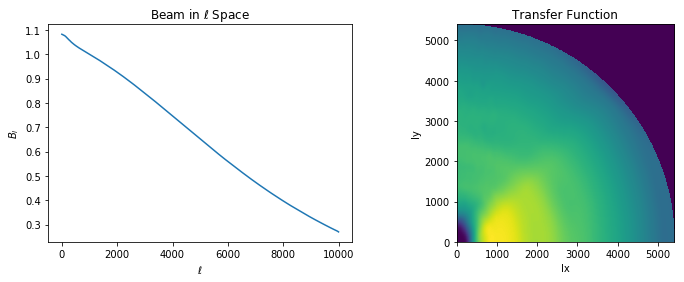

In [28]:
pl.figure(figsize=(12,4))
pl.subplot(121)
pl.plot(bl)
pl.xlabel(r'$\ell$')
pl.ylabel('$B_l$')
pl.title(r'Beam in $\ell$ Space')
pl.subplot(122)
# Only plot half of the 2D transfer function; the other half is similar
npix = len(tf['T'])
pl.imshow(tf['T'][0:npix//2,:][::-1,:].astype(float), extent = [0,5400,0,5400])
pl.xlabel('lx')
pl.ylabel('ly')
pl.title('Transfer Function')

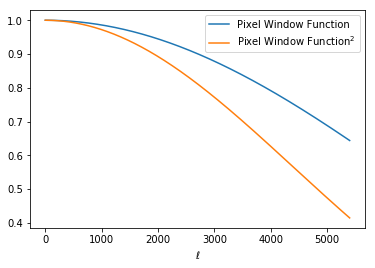

In [29]:
pl.plot(pixel_window_function, label='Pixel Window Function')
pl.plot(pixel_window_function**2, label=r'Pixel Window Function$^2$')
pl.xlabel(r'$\ell$')
pl.legend()

### From input TQU, calculate TEB spectra and see if they match theory, and confirm that our input TQU are unbeamed

In [30]:
# Get power spectra from the input TQU
g3file = core.G3File('/home/yukanakato/spt3g_software_tutorial/qest/run_01/sims_t1p1/sim_0.g3')
frame = g3file.next()
# Here, b_mode_method='chi', which removes E to B leakage
cl_0 = map_analysis.calculate_powerspectra(frame,
                                           lbins=np.arange(50,5000,30),
                                           apod_mask=apod150,
                                           flatten=True,
                                           b_mode_method='chi')
cltt_0 = cl_0['TT']
clee_0 = cl_0['EE']
clbb_0 = cl_0['BB']

In [31]:
# For the theory spectrum, we usually need to multiply it by the beam squared to "observe" it
# Here, the beam is just an array of ones, but we'll still explicitly do the multiplication
bl_ones = np.ones(lmax_theoryspec+1)

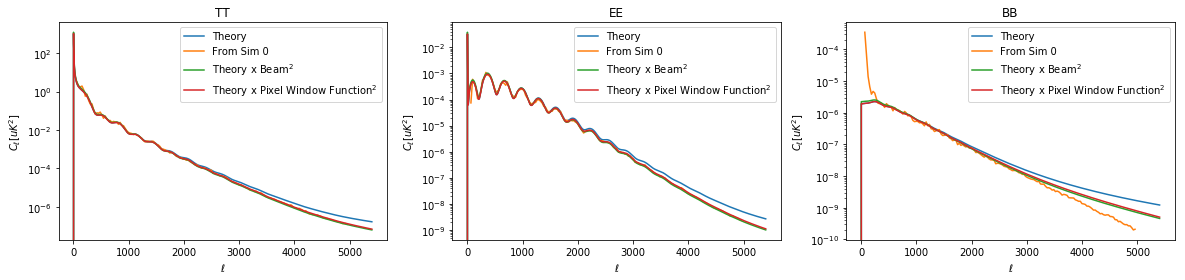

In [32]:
# Plot
bin_centers = (np.arange(50, 5000, 30) + 15)[:-1]
pl.figure(figsize=(20,4))

pl.subplot(131)
pl.plot((cltt*bl_ones**2)/uK**2, label='Theory')
pl.plot(bin_centers, cltt_0/uK**2, label='From Sim 0')
pl.plot((cltt*bl[0:5401]**2)/uK**2, label=r'Theory x Beam$^2$')
pl.plot((cltt*pixel_window_function[0:5401]**2)/uK**2, label=r'Theory x Pixel Window Function$^2$')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell [uK^2]$')
pl.legend()
pl.title('TT')
pl.yscale('log')

pl.subplot(132)
pl.plot((clee*bl_ones**2)/uK**2, label='Theory')
pl.plot(bin_centers, clee_0/uK**2, label='From Sim 0')
pl.plot((clee*bl[0:5401]**2)/uK**2, label=r'Theory x Beam$^2$')
pl.plot((clee*pixel_window_function[0:5401]**2)/uK**2, label=r'Theory x Pixel Window Function$^2$')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell [uK^2]$')
pl.legend()
pl.title('EE')
pl.yscale('log')

pl.subplot(133)
pl.plot((clbb*bl_ones**2)/uK**2, label='Theory')
pl.plot(bin_centers, clbb_0/uK**2, label='From Sim 0')
pl.plot((clbb*bl[0:5401]**2)/uK**2, label=r'Theory x Beam$^2$')
pl.plot((clbb*pixel_window_function[0:5401]**2)/uK**2, label=r'Theory x Pixel Window Function$^2$')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell [uK^2]$')
pl.legend()
pl.title('BB')
pl.yscale('log')

The inputs are not beamed, but we are seeing the pixel window function, which has a similar effect as the beam.

### Observation libraries

Now pull a sim and add noise to it.

In [33]:
# Lensed sims (signal and noise)
obs_len = sl.obs.ObsHomogeneousNoise(data=None,
                                     signal_lib=cmblib_len_t1p1, # Needs to be a SimLib object for it to work
                                     tq=tq_leak, tu=tu_leak,
                                     thresh=1000.0*uK,
                                     tcal=1.0, pcal=pcal,
                                     nlev_t=nlev_t,
                                     nlev_p=nlev_p)

# Unlensed sims
obs_unl = sl.obs.ObsHomogeneousNoise(data=None,
                                     signal_lib=cmblib_unl_t1p1,
                                     tq=tq_leak, tu=tu_leak,
                                     thresh=1000.0*uK,
                                     tcal=1.0, pcal=pcal)

# For N1 bias; nofg means no foreground; t2p1 means same lensing realizations but different CMB realizations
# No foreground is needed for N1 bias
obs_len_t2_nofg = sl.obs.ObsHomogeneousNoise(cmblib_len_t2p1_nofg,
                                             thresh=1000.0*uK,)
# For calculating the N1 bias as: len_t2 - len_nofg; t1p1 means different lensing realizations and different CMB realizations
obs_len_t1_nofg = sl.obs.ObsHomogeneousNoise(cmblib_len_t1p1,
                                             thresh=1000.0*uK,)

### Plot one lensed sim and one corresponding unlensed sim

In [34]:
obs_len_sim0 = obs_len.get_sim_tqu(0)

# These have noise already added to it
tmap_lensed = obs_len_sim0['T']
qmap_lensed = obs_len_sim0['Q']
umap_lensed = obs_len_sim0['U']

tmap_unlensed = obs_unl.get_sim_tqu(0)['T']

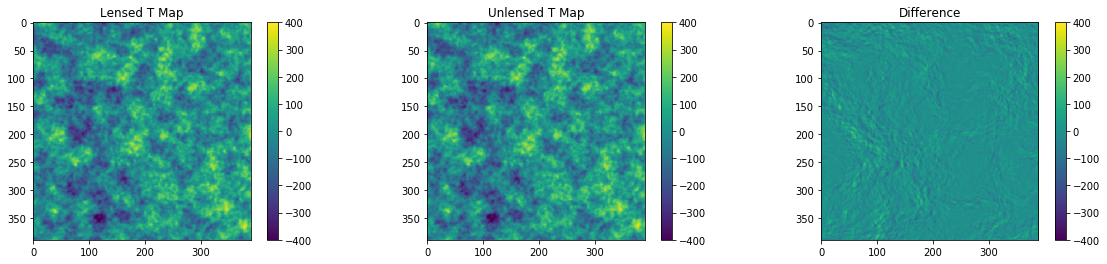

In [35]:
pl.figure(figsize=(20,4))
pl.subplot(131)
# Plot in IAU convention, the map unit is uK (convert from G3 units)
pl.imshow(tmap_lensed/uK, vmin=-400, vmax=400)
pl.title('Lensed T Map')
pl.colorbar()

pl.subplot(132)
# Plot in IAU convention, the map unit is uK
pl.imshow(tmap_unlensed/uK, vmin=-400, vmax=400)
pl.title('Unlensed T Map')
pl.colorbar()
pl.subplot(133)
pl.imshow((tmap_lensed-tmap_unlensed)/uK, vmin=-400, vmax=400)
pl.title('Difference')
pl.colorbar()

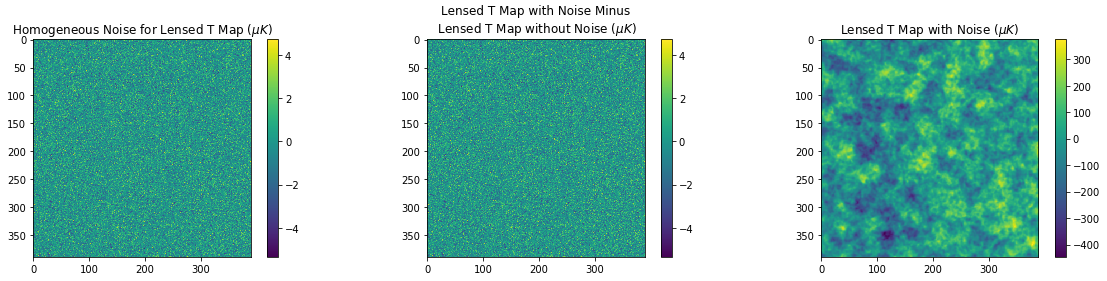

In [36]:
# Look at a homogeneous white noise TQU realization
pl.figure(figsize=(20,4))

pl.subplot(131)
homogeneous_noise = obs_len.get_sim_tqu_noise(0)
pl.imshow(homogeneous_noise['T']/uK)
pl.title('Homogeneous Noise for Lensed T Map ($\mu K$)')
pl.colorbar()

pl.subplot(132)
pl.imshow((tmap_lensed-tqu_0['T'])/uK)
pl.title('Lensed T Map with Noise Minus\n Lensed T Map without Noise ($\mu K$)')
pl.colorbar()

pl.subplot(133)
pl.imshow(tmap_lensed/uK)
pl.title('Lensed T Map with Noise ($\mu K$)')
pl.colorbar()

### Plot TT, EE, BB spectra after adding the homogeneous noise to the maps; overlay them with theory $C_\ell$ and $N_\ell$ spectra

Try getting the power spectra of the simulated noise and signal. To use the function `calculate_powerspectra`, we need to take the maps that are type `spt3g.maps.FlatSkyMap` and convert them into frame form.

In [38]:
frames_signal = core.G3File('/home/yukanakato/spt3g_software_tutorial/qest/run_01/sims_t1p1/sim_0.g3')

signal_frame = frames_signal.next()

noise_frame = core.G3Frame(core.G3FrameType.Map)
noise_frame['T'] = homogeneous_noise['T']
noise_frame['Q'] = homogeneous_noise['Q']
noise_frame['U'] = homogeneous_noise['U']

signal_and_noise_frame = core.G3Frame(core.G3FrameType.Map)
signal_and_noise_frame['T'] = tmap_lensed
signal_and_noise_frame['Q'] = qmap_lensed
signal_and_noise_frame['U'] = umap_lensed

In [39]:
# Get power spectra
cl_with_noise_0 = map_analysis.calculate_powerspectra(signal_and_noise_frame,
                                                      lbins=np.arange(50,5000,30),
                                                      apod_mask=apod150,
                                                      flatten=True,
                                                      b_mode_method='basic')
cltt_with_noise_0 = cl_with_noise_0['TT']
clee_with_noise_0 = cl_with_noise_0['EE']
clbb_with_noise_0 = cl_with_noise_0['BB']

# Or do signal and noise separately (same result)
cl_signal_0 = map_analysis.calculate_powerspectra(signal_frame,
                                                  lbins=np.arange(50,5000,30),
                                                  apod_mask=apod150,
                                                  flatten=True,
                                                  b_mode_method='basic')
cl_noise_0 = map_analysis.calculate_powerspectra(noise_frame,
                                                 lbins=np.arange(50,5000,30),
                                                 apod_mask=apod150,
                                                 flatten=True,
                                                 b_mode_method='basic')
cltt_with_noise_0 = cl_signal_0['TT'] + cl_noise_0['TT']
clee_with_noise_0 = cl_signal_0['EE'] + cl_noise_0['EE']
clbb_with_noise_0 = cl_signal_0['BB'] + cl_noise_0['BB']

Text(0.5,0.98,'Noise')

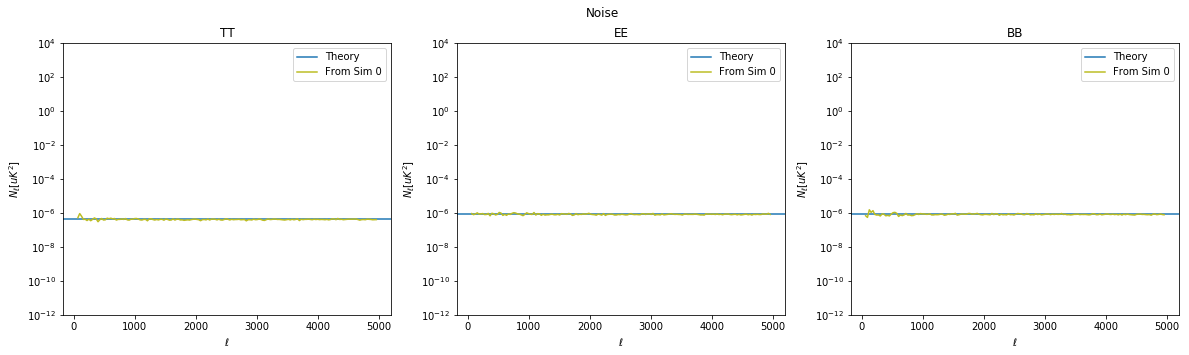

In [40]:
# Plot noise only (theory noise spectra don't have to be multiplied by the pixel window function squared)
pl.figure(figsize=(20,5))

pl.subplot(131)
pl.axhline(y=nltt/uK**2, label='Theory', color='tab:blue')
pl.plot(bin_centers, cl_noise_0['TT']/uK**2, label='From Sim 0', color='tab:olive')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$N_\ell [uK^2]$')
pl.legend()
pl.title('TT')
pl.yscale('log')
pl.ylim(1e-12,1e4)

pl.subplot(132)
pl.axhline(y=nlee/uK**2, label='Theory', color='tab:blue')
pl.plot(bin_centers, cl_noise_0['EE']/uK**2, label='From Sim 0', color='tab:olive')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$N_\ell [uK^2]$')
pl.legend()
pl.title('EE')
pl.yscale('log')
pl.ylim(1e-12,1e4)

pl.subplot(133)
pl.axhline(y=nlbb/uK**2, label='Theory', color='tab:blue')
pl.plot(bin_centers, cl_noise_0['BB']/uK**2, label='From Sim 0', color='tab:olive')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$N_\ell [uK^2]$')
pl.legend()
pl.title('BB')
pl.yscale('log')
pl.ylim(1e-12,1e4)
pl.suptitle('Noise')

Text(0.5,0.98,'Signal')

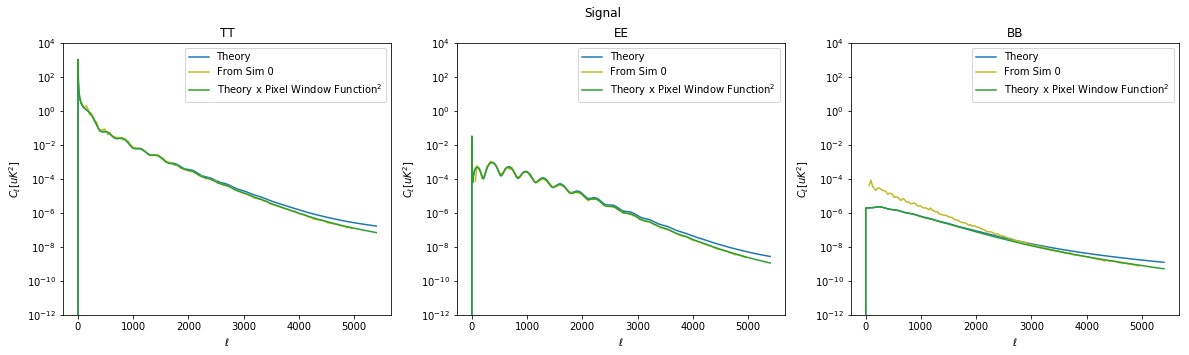

In [41]:
# Plot signal only (BB at low ells diverge from theory due to E to B leakage)
pl.figure(figsize=(20,5))

pl.subplot(131)
pl.plot((cltt)/uK**2, label='Theory', color='tab:blue')
pl.plot(bin_centers, cl_signal_0['TT']/uK**2, label='From Sim 0', color='tab:olive')
pl.plot((cltt*pixel_window_function[0:5401]**2)/uK**2, label=r'Theory x Pixel Window Function$^2$', color='tab:green')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell [uK^2]$')
pl.legend()
pl.title('TT')
pl.yscale('log')
pl.ylim(1e-12,1e4)

pl.subplot(132)
pl.plot((clee)/uK**2, label='Theory', color='tab:blue')
pl.plot(bin_centers, cl_signal_0['EE']/uK**2, label='From Sim 0', color='tab:olive')
pl.plot((clee*pixel_window_function[0:5401]**2)/uK**2, label=r'Theory x Pixel Window Function$^2$', color='tab:green')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell [uK^2]$')
pl.legend()
pl.title('EE')
pl.yscale('log')
pl.ylim(1e-12,1e4)

pl.subplot(133)
pl.plot((clbb)/uK**2, label='Theory', color='tab:blue')
pl.plot(bin_centers, cl_signal_0['BB']/uK**2, label='From Sim 0', color='tab:olive')
pl.plot((clbb*pixel_window_function[0:5401]**2)/uK**2, label=r'Theory x Pixel Window Function$^2$', color='tab:green')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell [uK^2]$')
pl.legend()
pl.title('BB')
pl.yscale('log')
pl.ylim(1e-12,1e4)
pl.suptitle('Signal')

Text(0.5,0.98,'With Noise')

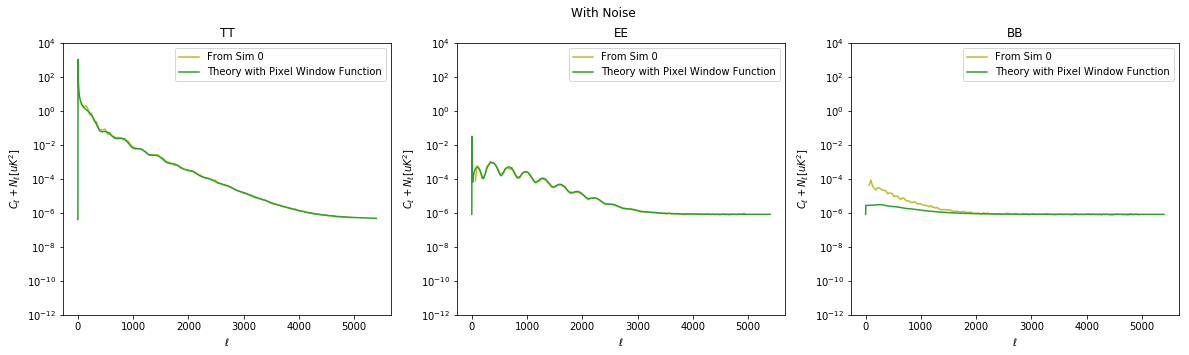

In [42]:
# Plot
pl.figure(figsize=(20,5))

pl.subplot(131)
pl.plot(bin_centers, cltt_with_noise_0/uK**2, label='From Sim 0', color='tab:olive')
pl.plot((cltt*pixel_window_function[0:5401]**2+nltt)/uK**2, label=r'Theory with Pixel Window Function', color='tab:green')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell + N_\ell [uK^2]$')
pl.legend()
pl.title('TT')
pl.yscale('log')
pl.ylim(1e-12,1e4)

pl.subplot(132)
pl.plot(bin_centers, clee_with_noise_0/uK**2, label='From Sim 0', color='tab:olive')
pl.plot((clee*pixel_window_function[0:5401]**2+nlee)/uK**2, label=r'Theory with Pixel Window Function', color='tab:green')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell + N_\ell [uK^2]$')
pl.legend()
pl.title('EE')
pl.yscale('log')
pl.ylim(1e-12,1e4)

pl.subplot(133)
pl.plot(bin_centers, clbb_with_noise_0/uK**2, label='From Sim 0', color='tab:olive')
pl.plot((clbb*pixel_window_function[0:5401]**2+nlbb)/uK**2, label=r'Theory with Pixel Window Function', color='tab:green')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$C_\ell + N_\ell [uK^2]$')
pl.legend()
pl.title('BB')
pl.yscale('log')
pl.ylim(1e-12,1e4)
pl.suptitle('With Noise')

### Inverse variance filtering

We need to inverse variance filter the data maps to boost the signal to noise before passing to the quadratic estimator. This step extracts weighted Fourier modes to reduce the estimator scatter.

To explain this step, we first define the data maps and sky signal:
 * $d\in[T(\hat{\mathbf{n}}), Q(\hat{\mathbf{n}}), U(\hat{\mathbf{n}})]$ is the data matrix. $d_j$ is the map value of the $j$th pixel.
 * $X_{\mathbf{l}}\in[T(\mathbf{l}), E(\mathbf{l}), B(\mathbf{l})]$ is the T/E/B sky signal. 

The data maps are related to the sky signal by:

$d_j = \sum_{\mathbf{l}} P_{j\mathbf{l}}X_{\mathbf{l}}+\sum_{\mathbf{l}} P_{j\mathbf{l}}N_{\mathbf{l}}+ n_j$

  * Here $P_{j\mathbf{l}}$ is a matrix operator that includes the transfer function, Fourier Transform, and Q/U to E/B conversion. 

    * For temperature the operator is:

      * $P_{j\mathbf{l}} = e^{i\mathbf{l}\mathbf{x}_j}F_{\mathbf{l}} $, where $F_{\mathbf{l}}$ is the transfer function, which includes beam, pixelization and timestream filtering.

    * For E/B, this operator is:
 
      * $P_{j\mathbf{l}} = e^{i\mathbf{l}\mathbf{x}_j\pm 2i\phi_{\mathbf{l}}}F_{\mathbf{l}} $, which also includes the Fourier space angle $\phi_{\mathbf{l}}$ for the Q/U to E/B conversion.

  * $N_{\mathbf{l}}$ is the sky noise that doesn't trace the CMB, such as foreground and atmosphere noise.

  * $n_j$ is the map noise. 

The formula for inverse-variance filtering is:

 $\overline X = S^{-1}[S^{-1}+P^{\dagger}n^{-1}P]^{-1} P^{\dagger}n^{-1}d$ 


 * $\overline X$ is the inverse-variance filtered fields. $\overline X = S^{-1} \hat{X}$, where $\hat{X}$ is the estimation of field $X$. 

 * $S = C_l^X + C_{\mathbf{l}}^N$, where $C_l^X$ is the theoretical power spectrum and $C_{\mathbf{l}}^N$ is the 2D power spectrum of the noise. 

 * $P$ is the "pointing matrix" which transfers the T/Q/U data in real space into T/E/B modes in ell space. $P$ was defined above.

### Code implementation

The inverse noise matrix $n^{-1}$ is calculated by the function `make_tqumap_wt` in `lensing/map_spec_utils.py`. If the white noise level arguments `nlev_tp` are given, it will just return inverse white noise squared.

The $S^{-1}$ part is done using `lensing/cinv_utils/opfilt_teb.py`.

In [43]:
print("Inverse variance filtering: getting n^{-1} (ninv)...")
ninv = sl.map_spec_utils.make_tqumap_wt(ninv=None,
                                        parent=parent,
                                        ninv_dcut=None,
                                        nlev_tp=(nlev_t, nlev_p),
                                        mask=apod150,)

# Map space noise 
# Since our input TQU are unbeamed, we don't need to divide by the beam transfer function, so use tf_ones instead of tf
ninvfilt = sl.cinv_utils.opfilt_teb.NoiseInverseFilter(tf_ones, ninv)

print("Inverse variance filtering: getting S^{-1} (sinv)...")
# Need to delete clte, otherwise the iteration for solving matrix inversion won't converge
cl_len_filt = {}
for k in cl_len.keys():
    cl_len_filt[k] = cl_len[k][0:lmax_sinv+1]
del cl_len_filt["TE"]  # Theoretical spectrum

# Includes signal and Fourier space noise
# In our case, just the same as cl_len_filt (no foregrounds)
total_cl = cl_len_filt

# Sky noise (in our case, zero because no foregrounds)
nl2d = MapSpectraTEB(
    ffts=[
        np.array(np.zeros((390, 390//2+1))),
        np.array(np.zeros((390, 390//2+1))),
        np.array(np.zeros((390, 390//2+1))),
    ],
    parent=parent,
)

# Calculate S^{-1}
sinvfilt = sl.cinv_utils.opfilt_teb.cl2sinv(total_cl, nl2d, tf_ones, nft=nlev_t, nfp=nlev_p, lmax=lmax_sinv)

print("Inverse variance filtering: doing the filtering (cinv)...")
# Here we do the inversion in iterations, eps_min is the convergence criterion
# Inverse variance filtered lensed sims (and data)
cinv_len = sl.cinv.CinvFilt(obs_len, # Signal and noise
                            sinvfilt, # Signal filter
                            ninvfilt, # Noise filter
                            lib_dir=lib_dir+"cinv_len_t1p1/", # Location for storing covariance inverse filtered maps
                            eps_min=5e-5,)
# Mask out the high ells
cinv_len = sl.cinv.CinvFiltMasked(lmin=lmin_cinv, lxmin=lxmin_cinv, lmax=lmax_cinv, cinv=cinv_len)

# Inverse variance filtered unlensed sims
cinv_unl = sl.cinv.CinvFilt(obs_unl,
                            sinvfilt,
                            ninvfilt,
                            lib_dir=lib_dir+"cinv_unl_t1p1/",
                            eps_min=5e-5,)
# Mask out the high ells
cinv_unl = sl.cinv.CinvFiltMasked(lmin=lmin_cinv, lxmin=lxmin_cinv, lmax=lmax_cinv, cinv=cinv_unl)

# Lensed sims with no foregrounds
cinv_len_t2_nofg = sl.cinv.CinvFilt(obs_len_t2_nofg,
                                    sinvfilt,
                                    ninvfilt,
                                    lib_dir="cinv_len_t2p1_nofg/",
                                    eps_min=5e-5,)
cinv_len_t2_nofg = sl.cinv.CinvFiltMasked(lmin=lmin_cinv, lxmin=lxmin_cinv, lmax=lmax_cinv, cinv=cinv_len_t2_nofg)

# Lensed sims with no foregrounds
cinv_len_t1_nofg = sl.cinv.CinvFilt(obs_len_t1_nofg,
                                    sinvfilt,
                                    ninvfilt,
                                    lib_dir="cinv_len_t1p1_nofg/",
                                    eps_min=5e-5,)
cinv_len_t1_nofg = sl.cinv.CinvFiltMasked(lmin=lmin_cinv, lxmin=lxmin_cinv, lmax=lmax_cinv, cinv=cinv_len_t1_nofg)

# Separate these out, since different numbers of sims are used for different purposes
ivflibs = [cinv_len, cinv_len_t1_nofg, cinv_len_t2_nofg] # Everything, used for get_dat_teb()
ivflibs_mc_sims = [cinv_len] # Evaluate for idxs in mc_sims
ivflibs_mc_sims_n1 = [cinv_len_t2_nofg, cinv_len_t1_nofg] # Evaluate for idxs in mc_sims_mf
ivflibs_mc_sims_unl = [cinv_unl] # Evaluate for idxs in mc_sims_unl

Inverse variance filtering: getting n^{-1} (ninv)...
Inverse variance filtering: getting S^{-1} (sinv)...
Inverse variance filtering: doing the filtering (cinv)...


Do cinv for one sim and look at it.
Compare with the original data map. 

In [44]:
cinv_1 = cinv_len.get_sim_teb(0) # Do inverse-variance filtering for sim with index 0

Text(0.5,1,'T map before cinv filtering')

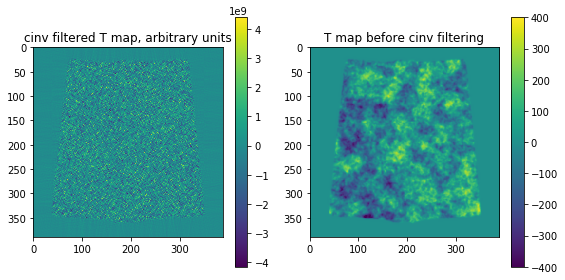

In [45]:
pl.figure(figsize=(8,4))

pl.subplot(121)
tmap_lensed = obs_len.get_sim_tqu(0)['T']
pl.imshow(cinv_1.get_tqu()['T'])
pl.colorbar()
pl.title('cinv filtered T map, arbitrary units')

pl.subplot(122)
pl.imshow((apod150*tmap_lensed)/uK, vmin=-400, vmax=400)
pl.colorbar()
pl.tight_layout()
pl.title('T map before cinv filtering')

### Sanity check the inverse variance filtering

Using the T map $T(\hat{\mathbf{n}})$ as an example (similarly for the E and B maps), inverse variance filtering does essentially $\frac{T(\hat{\mathbf{n}})+n(\hat{\mathbf{n}})}{C_\ell^{TT}+N_\ell^{TT}}$. Note that the units are changed; to preserve the units, for our sanity check we can multiply by $C_\ell^{TT}$, making it a Wiener filter: $\frac{C_\ell^{TT}}{C_\ell^{TT}+N_\ell^{TT}} \times (T(\hat{\mathbf{n}})+n(\hat{\mathbf{n}}))$.

Text(0.5,1,'T map before cinv filtering')

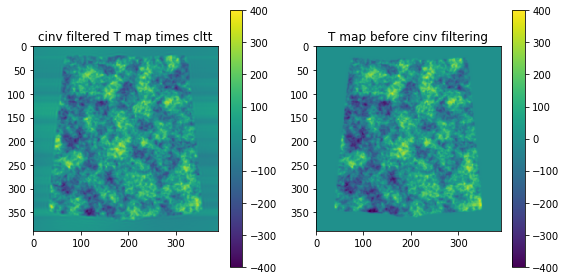

In [46]:
binned_lbins = np.arange(50, 5000, 30)

# Multiply the inverse variance filtered maps with the corresponding power spectra
cltt_wf = cltt * pixel_window_function[0:5401]**2
clee_wf = clee * pixel_window_function[0:5401]**2
clbb_wf = clbb * pixel_window_function[0:5401]**2

cltt_wf_binned = MapSpectrum1D(np.arange(5402), cltt_wf, 'cl', parent).rebin(binned_lbins)
clee_wf_binned = MapSpectrum1D(np.arange(5402), clee_wf, 'cl', parent).rebin(binned_lbins)
clbb_wf_binned = MapSpectrum1D(np.arange(5402), clbb_wf, 'cl', parent).rebin(binned_lbins)

cinv_tfft_cltt = (cinv_1*cltt_wf_binned)['T']
cinv_efft_clee = (cinv_1*clee_wf_binned)['E']
cinv_bfft_clbb = (cinv_1*clbb_wf_binned)['B']

# Sanity check that we approximately recover the input map if we plot the inverse variance filtered map times the spectrum
pl.figure(figsize=(8,4))

pl.subplot(121)
pl.imshow(cinv_tfft_cltt.get_map()/uK, vmin=-400, vmax=400)
pl.colorbar()
pl.title('cinv filtered T map times cltt')

pl.subplot(122)
pl.imshow((apod150*tmap_lensed)/uK, vmin=-400, vmax=400)
pl.colorbar()
pl.tight_layout()
pl.title('T map before cinv filtering')

A bit more sanity checking:

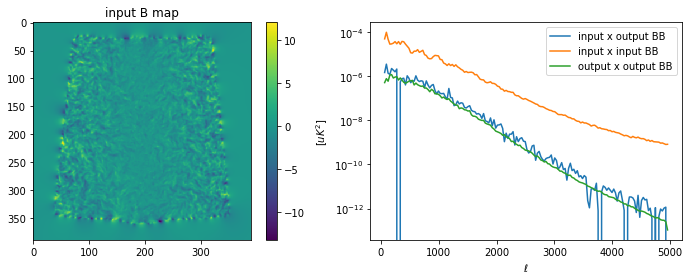

In [47]:
# Get power spectra from the input TQU
g3file = core.G3File(lib_dir+'sims_t1p1/sim_0.g3')
frame = g3file.next()
teb = map_spec_utils.calculate_teb(frame, apod_mask=apod150)

# Try plotting the input B map
pl.figure(figsize=(10,4))
pl.subplot(121)
pl.imshow(teb['B'].get_map()/uK)
pl.colorbar()
pl.tight_layout()
pl.title('input B map')

# Form a cross spectrum between the input B map and the output B and see if the recovered modes are correlated with the input
# Since input and output cross spectrum overlaps with the output auto spectrum, we can confirm that we added no additional modes to the input
input_output_cross_spectrum_bb = map_analysis.mapffts_to_powerspectra(input1=teb['B'], input2=cinv_bfft_clbb, lbins=np.arange(50,5000,30))
auto_spectrum_bb_input = map_analysis.mapffts_to_powerspectra(input1=teb['B'], lbins=np.arange(50,5000,30))
auto_spectrum_bb_output = map_analysis.mapffts_to_powerspectra(input1=cinv_bfft_clbb, lbins=np.arange(50,5000,30))

pl.subplot(122)
pl.semilogy(bin_centers, input_output_cross_spectrum_bb['TT']/uK**2, label='input x output BB')
pl.plot(bin_centers, auto_spectrum_bb_input['TT']/uK**2, label='input x input BB')
pl.plot(bin_centers, auto_spectrum_bb_output['TT']/uK**2, label='output x output BB')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$[uK^2]$')
pl.legend()

pl.tight_layout()

Final sanity check. We have $(T(\hat{\mathbf{n}})+n(\hat{\mathbf{n}}))^2 \times \frac{(C_\ell^{TT})^2}{(C_\ell^{TT}+N_\ell^{TT})^2} \sim (C_\ell^{TT}+N_\ell^{TT}) \times\frac{(C_\ell^{TT})^2}{(C_\ell^{TT}+N_\ell^{TT})^2}$. So, we will confirm that

`calculate_powerspectra(cinv['T'] * cltt)` or `calculate_powerspectra(cinv['T']) * cltt**2`

and

`cltt**2 / (cltt + nltt)`

are equivalent.

In [48]:
maskfac = np.mean(apod150**2)

ps_cinv_t = map_analysis.mapffts_to_powerspectra(cinv_tfft_cltt/maskfac**0.5, lbins=np.arange(50,5000,30))
ps_cinv_e = map_analysis.mapffts_to_powerspectra(cinv_efft_clee/maskfac**0.5, lbins=np.arange(50,5000,30))
ps_cinv_b = map_analysis.mapffts_to_powerspectra(cinv_bfft_clbb/maskfac**0.5, lbins=np.arange(50,5000,30))

# Alternatively, we can get the power spectra of the inverse variance filtered maps first, then multiply with spectra; we should get the same result
cinv_spectra = map_analysis.mapffts_to_powerspectra(input1=cinv_1/maskfac**0.5, lbins=np.arange(50,5000,30))

ps_cinv_tt = cinv_spectra['TT'] * cltt_wf_binned**2
ps_cinv_ee = cinv_spectra['EE'] * clee_wf_binned**2
ps_cinv_bb = cinv_spectra['BB'] * clbb_wf_binned**2

In [49]:
# Now do theory; multiply by the pixel window function squared for signal spectra
cltt_wf = cltt * pixel_window_function[0:5401]**2
clee_wf = clee * pixel_window_function[0:5401]**2
clbb_wf = clbb * pixel_window_function[0:5401]**2

tt_theory = cltt_wf**2 / (cltt_wf+nltt)
ee_theory = clee_wf**2 / (clee_wf+nlee)
bb_theory = clbb_wf**2 / (clbb_wf+nlbb)

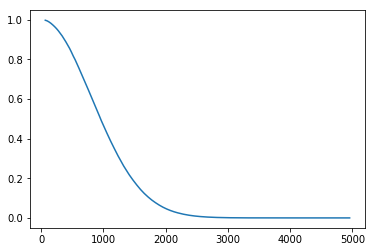

In [50]:
# Need to smooth by a 10 arcmin beam because dividing by C_l + N_l blows up the small scale noise
# Without smoothing only noise is visible
bll = get_beams(fwhm_150=10., lmax=5400)
bl = bll[150]

bl_binned = MapSpectrum1D(np.arange(5402), bl, 'cl', parent).rebin(binned_lbins)
pl.plot(bin_centers, bl_binned)

(1e-14, 10000.0)

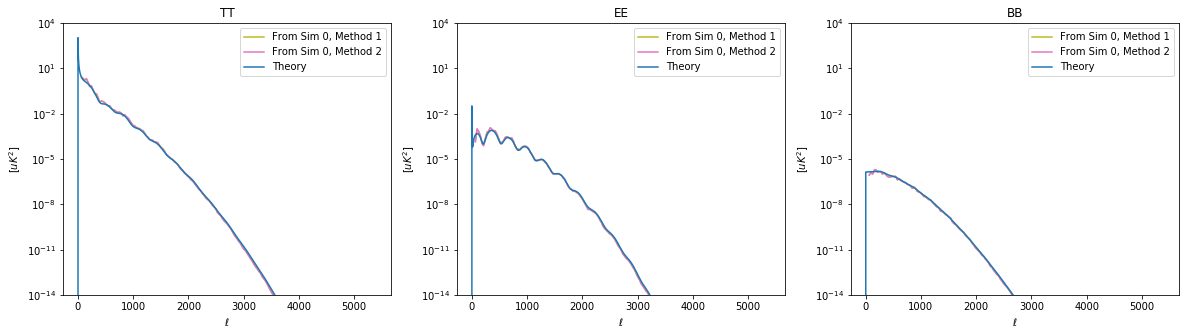

In [51]:
# Mismatch in BB might be due to a small mismatch in the interaction between the noise realization and the application of the transfer function in the filter
pl.figure(figsize=(20,5))

pl.subplot(131)
pl.plot(bin_centers, ps_cinv_t['TT']/uK**2 * bl_binned**2, label='From Sim 0, Method 1', color='tab:olive')
pl.plot(bin_centers, ps_cinv_tt/uK**2 * bl_binned**2, label='From Sim 0, Method 2', color='tab:pink')
pl.plot(tt_theory/uK**2 * bl**2, label=r'Theory', color='tab:blue')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$[uK^2]$')
pl.legend()
pl.title('TT')
pl.yscale('log')
pl.ylim(1e-14,1e4)

pl.subplot(132)
pl.plot(bin_centers, ps_cinv_e['TT']/uK**2 * bl_binned**2, label='From Sim 0, Method 1', color='tab:olive')
pl.plot(bin_centers, ps_cinv_ee/uK**2 * bl_binned**2, label='From Sim 0, Method 2', color='tab:pink')
pl.plot(ee_theory/uK**2 * bl**2, label=r'Theory', color='tab:blue')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$[uK^2]$')
pl.legend()
pl.title('EE')
pl.yscale('log')
pl.ylim(1e-14,1e4)

pl.subplot(133)
pl.plot(bin_centers, ps_cinv_b['TT']/uK**2 * bl_binned**2, label='From Sim 0, Method 1', color='tab:olive')
pl.plot(bin_centers, ps_cinv_bb/uK**2 * bl_binned**2, label='From Sim 0, Method 2', color='tab:pink')
pl.plot(bb_theory/uK**2 * bl**2, label=r'Theory', color='tab:blue')
pl.xlabel(r'$\ell$')
pl.ylabel(r'$[uK^2]$')
pl.legend()
pl.title('BB')
pl.yscale('log')
pl.ylim(1e-14,1e4)

### Quadratic estimator

Below is a brief review of the quadratic estimator. We'll go through how it works. For more details, see Hu & Okamoto: https://iopscience.iop.org/article/10.1086/341110/pdf

Weak lensing is a remapping of source to image planes by the gradient of the projected potential. Below we take the temperature field as an example. 

$T(\hat{\mathbf{n}}) = \tilde{T}(\hat{\mathbf{n}} + ∇\phi(\hat{\mathbf{n}})) = \tilde{T}(\hat{\mathbf{n}}) + \nabla _i \phi(\hat{\mathbf{n}})\nabla^{i}\tilde{T}(\hat{\mathbf{n}}) + $ higher order terms

Here $T$ is the lensed field, $\tilde{T}$ is the unlensed field, and $\phi$ is the projected lensing potential. 

$T(\hat{\mathbf{n}})$ and $\phi(\hat{\mathbf{n}})$ can be related to their Fourier transforms by: 

* $T(\hat{\mathbf{n}}) = \int\frac{d^2 l }{{(2\pi)}^2}T(\mathbf{l})e^{i\mathbf{l}\hat{\mathbf{n}}}$,  $T({\mathbf{l}}) = \int d \hat{\mathbf{n}} T(\hat{\mathbf{n}})e^{-i\mathbf{l}\hat{\mathbf{n}}}$
* $\phi(\hat{\mathbf{n}}) = \int\frac{d^2 l }{{(2\pi)}^2}\phi(\mathbf{l})e^{i\mathbf{l}\hat{\mathbf{n}}}$,  $\phi({\mathbf{l}}) = \int d \hat{\mathbf{n}} \phi(\hat{\mathbf{n}})e^{-i\mathbf{l}\hat{\mathbf{n}}}$

We expand the lensed field $T(\mathbf{l})$:

$T(\mathbf{l}) = \int d \hat{\mathbf{n}} T(\hat{\mathbf{n}})e^{-i\mathbf{l}\hat{\mathbf{n}}} = \int d \hat{\mathbf{n}} [\tilde{T}(\hat{\mathbf{n}})+ \nabla _i \phi(\hat{\mathbf{n}})\nabla^{i}\tilde{T}(\hat{\mathbf{n}})]  e^{-i\mathbf{l}\hat{\mathbf{n}}} = \tilde{T}(\mathbf{l}) - \int \frac{d\mathbf{l_1}}{{(2\pi)}^2}\tilde{T}(\mathbf{l_1})\mathbf{l_1}(\mathbf{l-l_1})\phi(\mathbf{l-l_1})$

Here we have used the convolution theorem when calculating the Fourier transform of $\nabla _i \phi(\hat{\mathbf{n}})\nabla^{i}\tilde{T}(\hat{\mathbf{n}})$. The subtracted term is exactly the $\delta T$ of Eq. 4 in Hu & Okamoto.

The power spectrum of temperature is defined as:
$<\tilde{T}^*(\mathbf{l})\tilde{T}(\mathbf{l^{\prime}})> = (2\pi)^2 \delta(\mathbf{l}-\mathbf{l^{\prime}})\tilde C_{l}^{TT}$

Using the previous two equations, we have:

$<T(\mathbf{l})T(\mathbf{l^{\prime}})>_{CMB} = [\tilde{C}_l^{TT}(\mathbf{l\cdot L})+\tilde{C}_{l^{\prime}}^{TT}(\mathbf{l^{\prime}\cdot L})]\phi(\mathbf{L}) = f(\mathbf{l},\mathbf{l^{\prime}}) \phi(\mathbf{L})$ 
 * $ f(\mathbf{l},\mathbf{l^{\prime}})= \tilde{C}_l^{TT}(\mathbf{l\cdot L})+\tilde{C}_{l^{\prime}}^{TT}(\mathbf{l^{\prime}\cdot L})$
 *  Here $\mathbf{L=l+l^{\prime}}$ and $\mathbf{L}\neq \mathbf 0$.
 *  $<>_{CMB}$ means we only average over the CMB realizations and not the LSS, otherwise $\phi(\mathbf{L})$ would average to 0. 

The power spectrum of $\phi$ is:

$<{\phi^*}(\mathbf{l})\phi(\mathbf{l^{\prime}})> = (2\pi)^2 \delta(\mathbf{l}-\mathbf{l^{\prime}}) C_l^{\phi\phi}$

Note that $<>$ means averaging over CMB and LSS (lensing) realizations. 

We define a weighting of the moments to extract the lensing potential:

$\hat{\phi}(\mathbf{L}) = R(\mathbf{L})^{-1} \int \frac{d^2\mathbf{l}}{{(2\pi)}^2}F(\mathbf{l}, \mathbf{l^{\prime}}) T(\mathbf{l})T(\mathbf{l^{\prime}})$
 * Again $\mathbf{L=l+l^{\prime}}$ and $\mathbf{L}\neq \mathbf 0 $.
 * Here $R(\mathbf{L})^{-1}$ is the normalization factor chosen such that $<\hat{\phi}(\mathbf{L})>_{CMB} = \phi (\mathbf{L})$.
 * The form of the weight, $F(\mathbf{l}, \mathbf{l^{\prime}})$ that minimizes the variance $<\hat{\phi}^{*}(\mathbf{L})\hat{\phi}(\mathbf{L})>- <\hat{\phi}^{*}(\mathbf{L})><\hat{\phi}(\mathbf{L})>$ is: $F(\mathbf{l}, \mathbf{l^{\prime}}) = f(\mathbf{l},\mathbf{l^{\prime}})/(2C_{l}^{TT}C_{l^{\prime}}^{TT}) $ 

Exercise: calculate the variance and try to minimize it. Verify the above $F$ minimizes the variance.

Several notes:
 * The form of $F(\mathbf{l}, \mathbf{l^{\prime}})$ is obtained by minimizing the variance of the estimated $\hat{\phi}$. 
 * $F(\mathbf{l}, \mathbf{l^{\prime}})$ is proportional to $f(\mathbf{l}, \mathbf{l^{\prime}})$ divided by the power spectrum of the fields used for the estimation. If the field contains sky noise $C_{\mathbf{l}}^N$, then the $C_{l}^{TT}$ in the denominator needs to be changed to $S = C_{l}^{TT}+C_{\mathbf{l}}^N$. 
 * **In our implementation of the quadratic estimator we define the weighting function to be $W(\mathbf{l}, \mathbf{l^{\prime}})= f(\mathbf{l}, \mathbf{l^{\prime}})/2$. The inverse variance filtering $S^{-1}$ takes care of the denominator in $F(\mathbf{l}, \mathbf{l^{\prime}})$.**
 * TE, EE, EB, and TB estimators are derived similarly, but a little more complicated due to the ell space angle in QU to EB conversion.

Exercise: from $Q\pm iU= -(E\pm iB)e^{\pm 2 i \phi_{\mathbf{l}}}$ and $[Q\pm iU](\hat{\mathbf{n}})= [\tilde{Q}\pm i\tilde{U}](\hat{\mathbf{n}})+ \nabla _i \phi(\hat{\mathbf{n}})\nabla^{i}[\tilde{Q}\pm i\tilde{U}](\hat{\mathbf{n}})$, derive $f(\mathbf{l}, \mathbf{l^{\prime}})$ for $<T(\mathbf{l})E(\mathbf{l^{\prime}})>_{CMB} = f(\mathbf{l}, \mathbf{l^{\prime}}) \phi(\mathbf{l+l^{\prime}})$.

### Biases in the power spectrum estimated from the  quadratic estimator

We estimate the power spectrum by $<\hat{\phi}^{*}(\mathbf{L})\hat{\phi}(\mathbf{L})>$.
Here, $\hat{\phi}(\mathbf{L}) = A(L) \int \frac{d^2\mathbf{l}}{{(2\pi)}^2}F(\mathbf{l}, \mathbf{l^{\prime}}) T(\mathbf{l})T(\mathbf{l^{\prime}})$. 
$\hat{\phi}$ means the estimated $\phi$. 

Note that conjugate in Fourier space is equivalent to switching $\mathbf{l}$ to $\mathbf{-l}$.

$<\hat{\phi}^{*}(\mathbf{L})\hat{\phi}(\mathbf{L^{\prime}})>$ is proportional to $\int d^2\mathbf{l_1}\int d^2 \mathbf{l_1^{\prime}}\, F(\mathbf{l_1}, \mathbf{l_2})F(\mathbf{l_1^{\prime}}, \mathbf{l_2^{\prime}})<T(\mathbf{-l_1})T(\mathbf{-l_2})T(\mathbf{l_1^{\prime}})T(\mathbf{l_2^{\prime}})>$

* Here $<T(\mathbf{-l_1})T(\mathbf{-l_2})T(\mathbf{l_1^{\prime}})T(\mathbf{l_2^{\prime}})>$ is a four-point correlation function. 
* $\mathbf{L}=\mathbf{l_1}+\mathbf{l_2}$
* $\mathbf{L^{\prime}}=\mathbf{l_1^{\prime}}+\mathbf{l_2^{\prime}}$

Using Wick's theorem, 

$<T(\mathbf{-l_1})T(\mathbf{-l_2})T(\mathbf{l_1^{\prime}})T(\mathbf{l_2^{\prime}})>$  =  $<<T(\mathbf{-l_1})T(\mathbf{-l_2})T(\mathbf{l_1^{\prime}})T(\mathbf{l_2^{\prime}})>_{CMB}>_{LSS}$ = 

$<<T(\mathbf{-l_1})T(\mathbf{-l_2})>_{CMB}<T(\mathbf{l_1^{\prime}})T(\mathbf{l_2^{\prime}})>_{CMB}>_{LSS}$    ----- (Term 1)

$+ <<T(\mathbf{-l_1})T(\mathbf{l_1^{\prime}})>_{CMB}<T(\mathbf{-l_2})T(\mathbf{l_2^{\prime}})>_{CMB}>_{LSS}$    ----- (Term 2)

$+ <<T(\mathbf{-l_1})T(\mathbf{l_2^{\prime}})>_{CMB}<T(\mathbf{-l_2})T(\mathbf{l_1^{\prime}})>_{CMB}>_{LSS}$    ----- (Term 3)

Remember that
 * $<T(\mathbf{l})T(\mathbf{l^{\prime}})>_{CMB} = C_{|\mathbf {l+l^{\prime}}|}\delta(\mathbf{l+l^{\prime}})+f(\mathbf{l},\mathbf{l^{\prime}}) \phi(\mathbf{L})$+ higher order terms
 * $<{\phi^*}(\mathbf{l})\phi(\mathbf{l^{\prime}})>_{LSS} = (2\pi)^2 \delta(\mathbf{l}-\mathbf{l^{\prime}}) C_{l}^{\phi\phi}$

Now we figure out each term:

* Term 1 = $(2\pi)^4 C_{l_1}^{TT}C_{l_1^{\prime}}^{TT} \delta(\mathbf{L}) \delta(\mathbf{L^{\prime}}) + C_{L}^{\phi\phi} f(\mathbf{l_1},\mathbf{l_2})f(\mathbf{l_1^{\prime}},\mathbf{l_2}^{\prime})$

* Term 2 = $(2\pi)^4 C_{l_1}^{TT}C_{l_2}^{TT} \delta(\mathbf{l_1^{\prime}-l_1}) \delta(\mathbf{l_2^{\prime}-l_2}) + C_{|\mathbf {l_1-l_1^{\prime}}|}^{\phi\phi} f(\mathbf{-l_1},\mathbf{l_1^{\prime}})f(\mathbf{-l_2},\mathbf{l_2}^{\prime})$

* Term 3 = $(2\pi)^4 C_{l_1}^{TT}C_{l_2}^{TT} \delta(\mathbf{l_2^{\prime}-l_1}) \delta(\mathbf{l_1^{\prime}-l_2}) + C_{|\mathbf {l_1-l_2^{\prime}}|}^{\phi\phi} f(\mathbf{-l_1},\mathbf{l_2^{\prime}})f(\mathbf{-l_2},\mathbf{l_1}^{\prime})$

Because $\mathbf{L}\neq \mathbf{0}$, the first term of Term 1 vanishes. The second term in Term 1 gives the $C_L^{\phi\phi}$ reconstruction and is the signal we want to extract.

Term 2 and Term 3 generate $n_0$ bias and $n_1$ bias:

 * The first term in Term 2 and the first term in Term 3 are 0th order of $C_{L}^{\phi\phi}$, and they give rise to the $n_0$ bias. 

 * The second term in Term 2 and the second term in Term 3 are 1st order of $C_{|\mathbf {l_1-l_1^{\prime}}|}^{\phi\phi}$ (or $C_{|\mathbf {l_1-l_2^{\prime}}|}^{\phi\phi}$), and they give rise to the $n_1$ bias.

### Implementation of bias calculation in the code
In the code, we do not calculate the biases analytically. We calculate them from many MC realizations of simulations.

* $N_0$ bias:
   * $\Delta C_{\mathbf{L}}^{\phi\phi}|_{N_0} = <C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC},\bar{V}_{MC^{\prime}},\bar{X}_{MC},\bar{Y}_{MC^{\prime}}]+C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC},\bar{V}_{MC^{\prime}},\bar{X}_{MC^{\prime}},\bar{Y}_{MC}]>$

     * Here $MC$ and $MC^{\prime}$ are MC realizations with random CMB and random LSS (lensing field). 
     * <> means averaging over different $MC$ and $MC^{\prime}$ realizations. 
     * $U,V,X,Y \in \{TEB\}$
     * $<C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC},\bar{V}_{MC^{\prime}},\bar{X}_{MC},\bar{Y}_{MC^{\prime}}]>$ is calculated by $<\hat{\phi}^{UV*}(\mathbf{L})\hat{\phi}^{XY}(\mathbf{L^{\prime}})>$, which is proportional to $\int d^2\mathbf{l_1}\int d^2 \mathbf{l_1^{\prime}}\, F(\mathbf{l_1}, \mathbf{l_2})F(\mathbf{l_1^{\prime}}, \mathbf{l_2^{\prime}})<\bar U_{MC}(\mathbf{-l_1})\bar V_{MC^{\prime}}(\mathbf{-l_2})\bar X_{MC}(\mathbf{l_1^{\prime}})\bar Y_{MC^{\prime}}(\mathbf{l_2^{\prime}})>$
     * Using Wick's theorem we can expand the above 4-pt correlation function into three terms, just like in the previous section. 
     * The only non-vanishing part comes from $<\bar U_{MC}(\mathbf{-l_1}) \bar X_{MC}(\mathbf{l_1^{\prime}})><\bar V_{MC^{\prime}}(\mathbf{-l_2}) \bar Y_{MC^{\prime}}(\mathbf{l_2^{\prime}})>$, which corresponds to the first term in Term 2 (see previous section). Other terms average to zero because the correlation between $MC$ and $MC^{\prime}$ averages to zero. **Kimmy and Zhaodi had some discussion whether the statement here is true. Please let them know if you have opinions.**
     * $MC$ and $MC^{\prime}$ have different $\phi$(LSS) realization, so there IS NO contribution to the first order of $C_L^{\phi\phi}$ ($\hat{\phi}^{MC, MC^{\prime}}$ average to zero). 
     * Similarly, $C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC},\bar{V}_{MC^{\prime}},\bar{X}_{MC^{\prime}},\bar{Y}_{MC}]$ corresponds to the first term in Term 3 (see previous section). 
     
* $N_1$ bias:
   * $\Delta C_{\mathbf{L}}^{\phi\phi}|_{N_1} = <C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC,\phi},\bar{V}_{MC^{\prime},\phi},\bar{X}_{MC,\phi},\bar{Y}_{MC^{\prime},\phi}]+C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC,\phi},\bar{V}_{MC^{\prime},\phi},\bar{X}_{MC^{\prime},\phi},\bar{Y}_{MC,\phi}] - \Delta C_{\mathbf{L}}^{\phi\phi}|_{N_0}>$

     * Here $(MC,\phi)$ and $(MC^{\prime},\phi)$ are MC realizations with random CMB but the same LSS (lensing field). 
     * $U,V,X,Y \in \{TEB\}$
     * Similar to the $N_0$ case, in $<C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC,\phi},\bar{V}_{MC^{\prime},\phi},\bar{X}_{MC,\phi},\bar{Y}_{MC^{\prime},\phi}]>$, the only non-vanishing part comes from $<\bar U_{MC}(\mathbf{-l_1}) \bar X_{MC}(\mathbf{l_1^{\prime}})><\bar V_{MC^{\prime}}(\mathbf{-l_2}) \bar Y_{MC^{\prime}}(\mathbf{l_2^{\prime}})>$, which corresponds to Term 2 (see previous section). 
     * $MC,\phi$ and $MC^{\prime},\phi$ have the same $\phi$(LSS) realization, so there IS contribution to the first order of $C_L^{\phi\phi}$. 
     * Similarly, $C_{\mathbf{L}}^{\hat{\phi}\hat{\phi}}[\bar{U}_{MC,\phi},\bar{V}_{MC^{\prime},\phi},\bar{X}_{MC^{\prime},\phi},\bar{Y}_{MC,\phi}]$ corresponds to Term 3 (see previous section).

### Implementation of quadratic estimator in the code

In the derivation above, we have

*  $\hat{\phi}(\mathbf{L}) = R(\mathbf{L})^{-1}\cdot \int \frac{d^2\mathbf{l}}{({2\pi})^2}F(\mathbf{l}, \mathbf{l^{\prime}}) T(\mathbf{l})T(\mathbf{l^{\prime}})$
    * Here $\mathbf{l^{\prime} } = \mathbf{L} - \mathbf{l} $

* $F(\mathbf{l}, \mathbf{l^{\prime}}) = f(\mathbf{l},\mathbf{l^{\prime}})/(2C_{l}^{TT}C_{l^{\prime}}^{TT}) $

In the lensing software we implement this in the following steps:

* Firstly we inverse-variance filter the fields: $\bar T= S^{-1} T$, which is essentially $\bar T = T/C_{l}^{TT}$ when there is no sky noise.

* We define our weighting function to be $W(\mathbf{l},\mathbf{l^{\prime}})=f(\mathbf{l},\mathbf{l^{\prime}})$. 

* We calculate our lensing reconstruction as
$\hat{\phi}(\mathbf{L}) =  R(\mathbf{L})^{-1} 2 \int \frac{d^2\mathbf{l}}{{2\pi}^2}W(\mathbf{l}, \mathbf{l^{\prime}}) \bar T(\mathbf{l})\bar T(\mathbf{l^{\prime}})$
 
   * Here $R_{\mathbf{L}}$ is the normalization function such that $<\hat{\phi}(\mathbf{L})>= \phi(\mathbf{L})$
   * The extra factor of 2 comes from the 2 in the denominator in $F$, which is NOT included in our $W$ function. 
   * The analytic form of $R^{Analytic}_{\mathbf{L}}$ is $R^{Analytic}_{\mathbf{L}}= \int d^2\mathbf{l}\,W(\mathbf{l}, \mathbf{l^{\prime}})W(\mathbf{l}, \mathbf{l^{\prime}}) F_{\mathbf l }F_{\mathbf {l^{\prime}} }$.
       * Here $F_{\mathbf l }$ is the transfer function, including filtering, pixelization, and beam. 
   * The analytic $R$ can be off because the transfer function may not be exact. We also use MC simulations to estimate $R$ from simulations. $R^{MC}(\mathbf{L}) = \frac{<\hat{\phi}(\mathbf{L})\phi^{I*}(\mathbf{L})>}{<\phi^{I}(\mathbf{L})\phi^{I*}(\mathbf{L})>}$
       * Here $\phi^{I*}$ is the input $\phi$ for the sims and $\hat{\phi}$ is the reconstructed $\phi$.
   * The full normalization is $R = R^{Analytic}R^{MC}$.
* Correct for the mean-field bias.
    * There may be some contribution to our $\phi$ estimation from statistical anisotropy induced by non-lensing sources such as the mask and inhomogeneous noise. These terms consistute a "mean-field" bias.
    * We calculate the mean-field bias $\bar{\phi}_{\mathbf L}^{MF}$ by averaging over 50 simulations with independent realizations of CMB and LSS but the same mask and inhomogeneous noise. The lensing signal should average out, leaving us with the mean-field bias. In $\bar{\phi}$ the bar means it's not corrected for the normalization $R$.  
    * We can compare the mean field bias with $n_0$ and $n_1$ bias. The mean field bias is for $\phi$, while $n_0$ and $n_1$ are for $C_L^{\phi\phi}$.
* Putting in the mean-field bias and the MC correction of the normalization function, the unbiased estimation of the $\phi$ is $\hat{\phi}(\mathbf{L}) = R(\mathbf{L})^{-1} 2 [\int \frac{d^2\mathbf{l}}{{2\pi}^2}W(\mathbf{l}, \mathbf{l^{\prime}}) \bar T(\mathbf{l})\bar T(\mathbf{l^{\prime}})-\bar{\phi}_{\mathbf L}^{MF}]$

### Definition of the weight functions in the code
In the lensing pipeline, the weighting function $W$ for $TT, TE, EE, EB, TB$ estimators are defined in `lensing/quadest_utils.py`.

In our implementation, $W$ for TT estimator is:

$W_{\mathbf{l}, \mathbf{l^{\prime}}}= [\tilde{C}_l^{TT}(\mathbf{l\cdot L})+\tilde{C}_{l^{\prime}}^{TT}(\mathbf{l^{\prime}\cdot L})]\phi(\mathbf{L})$

where

$\mathbf{l}\cdot\mathbf{L} = Ll\cos(\theta_0-\theta_L) = Ll\frac 1 2 (e^{i\theta_0}e^{-i\theta_L}+e^{-i\theta_0}e^{i\theta_L})$.

Here $\theta_0$ and $\theta_L$ are azimuthal angles of $l$ and $L$, respectively.

Expand $W$ as a function of azimuth angles of $\mathbf{l}, \mathbf{l^{\prime}}, \mathbf{L}$:

$W_{\mathbf{l}, \mathbf{l^{\prime}}} = {[(\frac 1 2 L e^{-i\theta_L})\tilde{C}_l^{TT}le^{i\theta_0}]+[(\frac 1 2 L e^{i\theta_L})\tilde{C}_l^{TT}le^{-i\theta_0}]+[(\frac 1 2 L e^{-i\theta_L})\tilde{C}_l^{\prime TT}l^{\prime}e^{i\theta^{\prime}}]+[(\frac 1 2 L e^{i\theta_L})\tilde{C}_l^{\prime TT}l^{\prime}e^{-i\theta^{\prime}}]}$

Each term above can be expressed as $F(\mathbf l)G(\mathbf {l^{\prime}})H(\mathbf L)$.
 * $F(\mathbf{l})= wl[i][0](l)e^{i(s[i][0])\theta_0}$
 * $G(\mathbf{l^{\prime}})= wl[i][1](l^{\prime})e^{i(s[i][1])\theta^{\prime}}$
 * $H(\mathbf{L})= wl[i][2](L)e^{i(s[i][2])\theta_L}$
 
For the 0th (i=0) term ($[(\frac 1 2 L e^{-i\theta_L})\tilde{C}_l^{TT}le^{i\theta_0}]$), decompose it to $F\cdot G\cdot H$, we have:

$F = \tilde{C}_l^{TT}le^{i\theta_0}$, $G = -\frac 1 2$, and $H =  L e^{-i\theta_L}$.

Note there is an extra minus sign in the code convention.

Therefore in `class QuadEst` of `spt3g_software/lensing/lensing/quadest_utils.py`
  * $wl[0][0]= \tilde{C}_l^{TT}l$, $s[0][0]=1$  (coefficients for F)
  * $wl[0][1]= -0.5 $, $s[0][1]=0$  (coefficients for G)
  * $wl[0][2]= L$, $s[0][2]=1$  (coefficients for H)

Exercise: fill up other matrix elements of $wl$ and $s$ for TT estimator, and compare to the code.

Snippets from `spt3g_software/lensing/lensing/qest_utils.py`, method `calc_weights(self, estimator_id, lx, ly)`:

```python
        assert (
            estimator_id in self.estimator_dict
        ), "{} is not a valid estimator ID.".format(estimator_id)

        l = np.sqrt(lx ** 2 + ly ** 2)
        cls = self.estimator_dict[estimator_id]["cls"]
        interp_cls = [np.interp(l, np.arange(len(cl)), cl, right=0) for cl in cls]

        if estimator_id == "Phi_TT":
            # phi estimated from TT
            wl = np.array(
                [
                    [l * interp_cls[0], -0.5, l],
                    [l * interp_cls[0], -0.5, l],
                    [-0.5, l * interp_cls[0], l],
                    [-0.5, l * interp_cls[0], l],
                ],
                dtype=object,
            )
            sl = np.array(
                [[+1, +0, +1], [-1, +0, -1], [+0, +1, +1], [+0, -1, -1]]
            )
```

The method that actually calculates the weighted moments of the two input fields is `eval(self, ft1, ft2, estimator_id, npad=None)`.

```python
        cfft = MapSpectrum2D(ft1.parent)
        lx, ly = cfft.get_lxly()
        psi = np.arctan2(lx, -ly)

        wl, sl = self.calc_weights(estimator_id, lx, ly)
        for i in range(wl.shape[0]):  # loop over terms
            term1 = wl[i, 0] * ft1 * np.exp(+1.0j * sl[i, 0] * psi)
            term2 = wl[i, 1] * ft2 * np.exp(+1.0j * sl[i, 1] * psi)
            cfft += (
                iconvolve_padded(term1, term2, npad=npad)
                * wl[i, 2]
                * np.exp(-1.0j * sl[i, 2] * psi)
                * 0.5
                / np.sqrt(cfft.dx * cfft.dy)
                * np.sqrt(cfft.map_nx * cfft.map_ny)
            )
        return cfft
```

The code `lensing/quadest.py` is a wrapper of `lensing/quadest_utils.py`.
You can use its `get_qft` method to get the weighted moments of the two input fields:
```python
    def get_qft(self, id, teb_dict1, teb_dict2):
        cfft = MapSpectrum2D(teb_dict1["T"].parent)
        estimator_ids = self.estimator_sets.get(id, [id])
        for estimator_id in estimator_ids:
            teb_key1, teb_key2 = self.quadest.estimator_dict[estimator_id][
                "fls"
            ]
            f1, f2 = teb_dict1[teb_key1], teb_dict2[teb_key2]
            cfft += self.quadest.eval(f1, f2, estimator_id)  # * tfe
        return cfft
```

`get_sim_qft` (used below) and `get_dat_qft` are wrappers of `get_qft`. 

In [52]:
# Define the qest object; the initialization requires the lensed and unlensed cls, as well as the cinv object
qest_dd = sl.quadest.QuadEstLib(cl_unl, cl_len, cinv_len,
                                lib_dir=lib_dir+'par_%s/qest_len_dd/' % qest_prefix)

Compare the reconstructed kappa map (

$\hat{\phi} = \frac{1}{R}\left(\bar{\phi}-\langle\bar{\phi}\rangle\right)$ converted to kappa) with the input kappa map.

Note that we need to subtract the mean field bias, which is calculated by `get_sim_qft_mf`.

`get_sim_qft_mf` basically runs `get_sim_qft` many times and averages over 50 simulations.

We also need to divide by the response function, which is calculated by `get_response`.

It basically calculates   $R^{Analytic}_{\mathbf{L}}= \int d^2\mathbf{l}\,W(\mathbf{l}, \mathbf{l^{\prime}})W(\mathbf{l}, \mathbf{l^{\prime}}) F_{\mathbf l }F_{\mathbf {l^{\prime}} }$, which was derived above. 


/home/yukanakato/spt3g_software/build/spt3g/mapspectra/map_spectrum_classes.py:85: RuntimeWarning: invalid value encountered in true_divide
  results = super().__array_ufunc__(ufunc, method, *args, **kwargs)


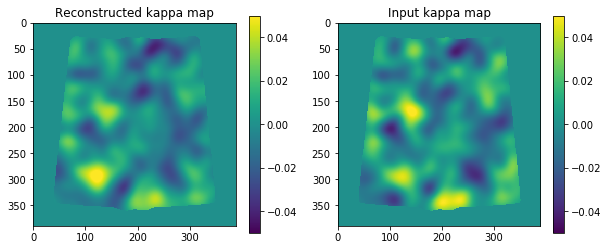

In [54]:
bl = get_beams(fwhm_150=60., lmax=8000) # Kappa convolved with 1 degree beam
bl = bl[150]

# Lensed sim plot
k = 'Phi_TT'
idx = 161 # Do this for sim 161
# Mask with no holes
mask_area = np.load('/scratch/panz/lens100d_py3/'+"inputs/mask/mask_surv_five_150.npy")

# We need to subtract the mean field bias from the weighted moments, and then divide the whole thing by the normalization factor qest_dd.get_response
kfft = (qest_dd.get_sim_qft(k,idx) - qest_dd.get_sim_qft_mf(k, mc_sims_mf))/qest_dd.get_response(k) # This is 390 x 390
# Have to get the ell values corresponding to each of the 390 x 390 Fourier modes; use get_ell
kfft = kfft * kfft.get_ell()**2/2. # Conversion from phi to kappa
kfft = kfft * -1 # Negative
kfft_with_beam = kfft * bl[kfft.get_ell().astype(int)] # Smooth with beam for plotting
# From FFT to map 
kmap = kfft_with_beam.get_map()

# Kappa input plot
kmap_load = sl.utils.read_map_frame(os.path.join(lib_dir, 'sims_kap', 'sim_{:n}.g3'.format(idx)))
kmap_load = kmap_load['Kap']
# Smooth by one degree beam; to do this, convert to Fourier space, multiply with the beam, then convert back to pixel space
kfft_input = basicmaputils.map_to_ft(kmap_load, apod_mask=apod150, res=res, real=False)
kfft_input_with_beam = kfft_input * bl[kfft_input.get_ell().astype(int)]
# From FFT to map 
kmap_input = kfft_input_with_beam.get_map()

# Plot
pl.figure(figsize=(10,4))

pl.subplot(121)
# Plot in IAU convention
pl.imshow(mask_area*kmap, vmin=-0.05, vmax=0.05)
pl.title('Reconstructed kappa map')
pl.colorbar()

pl.subplot(122)
pl.imshow(mask_area*kmap_input, vmin=-0.05, vmax=0.05)
pl.title('Input kappa map')
pl.colorbar()

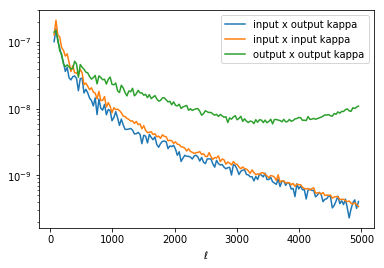

In [46]:
# Form cross spectrum for reconstruction as a sanity check
# The output kappa from the quadratic estimator is noisy (additional power at high ells)
# But since the cross spectrum matches the input auto, we know that we are retaining all the modes in the input map in the output map

input_output_cross_spectrum_kap = map_analysis.mapffts_to_powerspectra(input1=kfft_input, input2=kfft, lbins=np.arange(50,5000,30))
auto_spectrum_kap_input = map_analysis.mapffts_to_powerspectra(input1=kfft_input, lbins=np.arange(50,5000,30))
auto_spectrum_kap_output = map_analysis.mapffts_to_powerspectra(input1=kfft, lbins=np.arange(50,5000,30))

pl.figure()
pl.semilogy(bin_centers, input_output_cross_spectrum_kap['TT'], label='input x output kappa')
pl.plot(bin_centers, auto_spectrum_kap_input['TT'], label='input x input kappa')
pl.plot(bin_centers, auto_spectrum_kap_output['TT'], label='output x output kappa')
pl.xlabel(r'$\ell$')
pl.legend()